# Fault detection for INS of a ship described by Nomoto second order model

INS (Inertial navigation system) includes a gyriscope and accelerometer

## Data import and analysis

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
files = glob.glob('datasets/*.csv')

data = []
for file in files:
  if(file != 'data_model.csv'):
      data.append(pd.read_csv(file, usecols = ['u1', 'y1', 'y2', 'y_nominal1', 'y_nominal2', 'fault_u1',
       'fault_y1', 'fault_y2', 'comp_fault']))
      
len(data)

280

In [3]:
data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   u1          5000 non-null   float64
 1   y1          5000 non-null   float64
 2   y2          5000 non-null   float64
 3   y_nominal1  5000 non-null   float64
 4   y_nominal2  5000 non-null   float64
 5   fault_u1    5000 non-null   float64
 6   fault_y1    5000 non-null   float64
 7   fault_y2    5000 non-null   float64
 8   comp_fault  5000 non-null   float64
dtypes: float64(9)
memory usage: 351.7 KB


In [4]:
data[10].tail()

,u1,y1,y2,y_nominal1,y_nominal2,fault_u1,fault_y1,fault_y2,comp_fault
4995,-0.242389,0.660417,-0.523544,0.666114,-0.437085,0.0,0.0,0.0,0.0
4996,-0.245502,0.111651,0.143452,0.116322,0.049583,0.0,0.0,0.0,0.0
4997,-0.248291,0.713764,-0.436156,0.678814,-0.459262,0.0,0.0,0.0,0.0
4998,-0.250754,0.143939,0.137843,0.128858,0.036374,0.0,0.0,0.0,0.0
4999,-0.252888,0.668112,-0.447860,0.690622,-0.480836,0.0,0.0,0.0,0.0


Check fault cases

In [5]:
u1 = []
y1 = []
y2 = []
comp = []
for s in range(len(data)):
  df = data[s].loc[data[s]['fault_u1'] != 0]
  if (df.empty != True):
    u1.append(s)
  df = data[s].loc[data[s]['fault_y1'] != 0]
  if (df.empty != True):
    y1.append(s)
  df = data[s].loc[data[s]['fault_y2'] != 0]
  if (df.empty != True):
    y2.append(s)
  df = data[s].loc[(data[s]['fault_y2'] != 0) & (data[s]['fault_y1'] != 0)]
  if (df.empty != True):
    comp.append(s)

print('y1 faults in samples ', y1)
print('y2 faults in samples ', y2)

y1 faults in samples  [25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 216, 217, 218, 219, 220, 221, 222, 223, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 259]
y2 faults in samples  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 113, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 19

## Feature engineering

Add features:
- previous values for each measurement (parameter max_lag)
- rolling mean value (parameters rolling_mean_first_size and count_rolling)
- first derivative
- second derivative

In [6]:
def make_features(df, max_lag, rolling_mean_first_size, count_rolling):
    df_res = df.copy()
    # Add n lags
    for lag in range(1, max_lag + 1):
        df_res['y1_lag_{}'.format(lag)] = df_res['y1'].shift(lag)
        df_res['y2_lag_{}'.format(lag)] = df_res['y2'].shift(lag)
        df_res['y_nominal1_lag_{}'.format(lag)] = df_res['y_nominal1'].shift(lag)
        df_res['y_nominal2_lag_{}'.format(lag)] = df_res['y_nominal2'].shift(lag)
# Add rolling mean
    df_cols = ['y1',	'y2',	'y_nominal1',	'y_nominal2']
    for counts in range(1, (count_rolling + 1)):
      for rol in range(len(df_cols)):
        s = df_cols[rol]+'_rolling_mean_{}'.format(rolling_mean_first_size*counts)
        df_res[s] = df_res[df_cols[rol]].shift().rolling(rolling_mean_first_size*counts).mean()
        # Add first derivative
    if (max_lag > 0):
      df_res['Vy1'] = df_res['y1'] - df_res['y1_lag_1']
      df_res['Vy2'] = df_res['y2'] - df_res['y2_lag_1']
      df_res['Vy_nominal1'] = df_res['y_nominal1'] - df_res['y_nominal1_lag_1']
      df_res['Vy_nominal2'] = df_res['y_nominal2'] - df_res['y_nominal2_lag_1']
    if (max_lag > 1): # Add second derivative
      df_res['Ay1'] = df_res['Vy1'] - (df_res['y1_lag_1'] - df_res['y1_lag_2'])
      df_res['Ay2'] = df_res['Vy2'] - (df_res['y2_lag_1'] - df_res['y2_lag_2'])
      df_res['Ay_nominal1'] = df_res['Vy_nominal1'] - (df_res['y_nominal1_lag_1'] - df_res['y_nominal1_lag_2'])
      df_res['Ay_nominal2'] = df_res['Vy_nominal2'] - (df_res['y_nominal2_lag_1'] - df_res['y_nominal2_lag_2'])
    if (max_lag > 2): # Add third derivative
      df_res['jy1'] = df_res['Ay1'] - (df_res['y1_lag_1'] - 2*df_res['y1_lag_2'] + df_res['y1_lag_3'])
      df_res['jy2'] = df_res['Ay2'] - (df_res['y2_lag_1'] - 2*df_res['y2_lag_2'] + df_res['y2_lag_3'])
      df_res['jy_nominal1'] = df_res['Ay_nominal1'] - (df_res['y_nominal1_lag_1'] - 2*df_res['y_nominal1_lag_2'] + df_res['y_nominal1_lag_3'])
      df_res['jy_nominal2'] = df_res['Ay_nominal2'] - (df_res['y_nominal2_lag_1'] - 2*df_res['y_nominal2_lag_2'] + df_res['y_nominal2_lag_3'])

    df_res = df_res.dropna().reset_index(drop=True)
    return df_res

In [7]:
augmented_data = []
for df1 in data:
  augmented_data.append(make_features(df1, 2, 5, 2))

In [8]:
for df1 in augmented_data:
    df1['fault_y1'] = df1['fault_y1'].astype(int)
    df1['fault_y2'] = df1['fault_y2'].astype(int)
    df1['comp_fault'] = df1['comp_fault'].astype(int)

augmented_data[3].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4990 entries, 0 to 4989
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   u1                          4990 non-null   float64
 1   y1                          4990 non-null   float64
 2   y2                          4990 non-null   float64
 3   y_nominal1                  4990 non-null   float64
 4   y_nominal2                  4990 non-null   float64
 5   fault_u1                    4990 non-null   float64
 6   fault_y1                    4990 non-null   int32  
 7   fault_y2                    4990 non-null   int32  
 8   comp_fault                  4990 non-null   int32  
 9   y1_lag_1                    4990 non-null   float64
 10  y2_lag_1                    4990 non-null   float64
 11  y_nominal1_lag_1            4990 non-null   float64
 12  y_nominal2_lag_1            4990 non-null   float64
 13  y1_lag_2                    4990 

In [9]:
augmented_data[5].head()

,u1,y1,y2,y_nominal1,y_nominal2,fault_u1,fault_y1,fault_y2,comp_fault,y1_lag_1,...,y_nominal1_rolling_mean_10,y_nominal2_rolling_mean_10,Vy1,Vy2,Vy_nominal1,Vy_nominal2,Ay1,Ay2,Ay_nominal1,Ay_nominal2
0,-0.039957,0.867924,-0.348045,0.790151,-0.178005,0.0,0,0,0,0.669244,...,0.844345,-0.203428,0.198681,-0.261390,0.009357,0.043646,0.315508,-0.319497,0.027824,0.086733
1,-0.038765,0.734258,-0.151382,0.739086,-0.218638,0.0,0,0,0,0.867924,...,0.840439,-0.203204,-0.133666,0.196664,-0.051065,-0.040634,-0.332347,0.458054,-0.060422,-0.084280
2,-0.037560,0.784257,-0.196258,0.780521,-0.177390,0.0,0,0,0,0.734258,...,0.817173,-0.201768,0.050000,-0.044877,0.041435,0.041248,0.183666,-0.241540,0.092501,0.081882
3,-0.036344,0.725917,-0.074221,0.699555,-0.215558,0.0,0,0,0,0.784257,...,0.812941,-0.201516,-0.058340,0.122037,-0.080966,-0.038168,-0.108340,0.166913,-0.122402,-0.079415
4,-0.035117,0.763035,-0.158254,0.770429,-0.176721,0.0,0,0,0,0.725917,...,0.790882,-0.200045,0.037118,-0.084033,0.070874,0.038837,0.095458,-0.206069,0.151840,0.077005


In [10]:
all_data = pd.DataFrame()
for df in augmented_data:
  all_data = pd.concat([all_data, df], ignore_index = True)
all_data.drop(['fault_u1', 'comp_fault'], axis=1, inplace=True)

In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1397200 entries, 0 to 1397199
Data columns (total 31 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   u1                          1397200 non-null  float64
 1   y1                          1397200 non-null  float64
 2   y2                          1397200 non-null  float64
 3   y_nominal1                  1397200 non-null  float64
 4   y_nominal2                  1397200 non-null  float64
 5   fault_y1                    1397200 non-null  int32  
 6   fault_y2                    1397200 non-null  int32  
 7   y1_lag_1                    1397200 non-null  float64
 8   y2_lag_1                    1397200 non-null  float64
 9   y_nominal1_lag_1            1397200 non-null  float64
 10  y_nominal2_lag_1            1397200 non-null  float64
 11  y1_lag_2                    1397200 non-null  float64
 12  y2_lag_2                    1397200 non-null  float64
 1

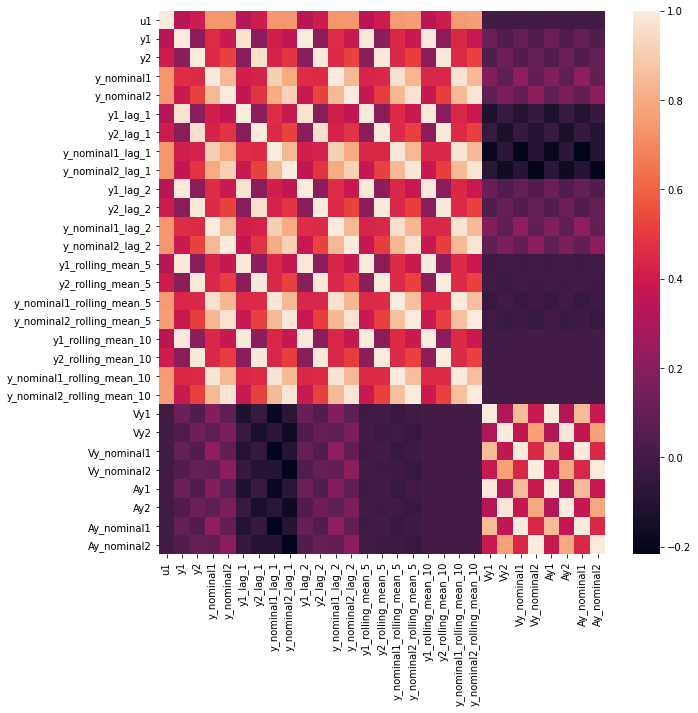

In [12]:
def _heatmap(df):
  df_features = df.drop(['fault_y1', 'fault_y2'], axis = 1)
  cor = df_features.corr()
  plt.figure(figsize = (10, 10))
  sns.heatmap(cor)
  plt.show
  del df_features
  
_heatmap(all_data)

In [13]:
all_data.describe()

,u1,y1,y2,y_nominal1,y_nominal2,fault_y1,fault_y2,y1_lag_1,y2_lag_1,y_nominal1_lag_1,...,y_nominal1_rolling_mean_10,y_nominal2_rolling_mean_10,Vy1,Vy2,Vy_nominal1,Vy_nominal2,Ay1,Ay2,Ay_nominal1,Ay_nominal2
count,1.397200e+06,1.397200e+06,1.397200e+06,1.397200e+06,1.397200e+06,1.397200e+06,1.397200e+06,1.397200e+06,1.397200e+06,1.397200e+06,...,1.397200e+06,1.397200e+06,1.397200e+06,1.397200e+06,1.397200e+06,1.397200e+06,1.397200e+06,1.397200e+06,1.397200e+06,1.397200e+06
mean,-2.890268e-02,-1.429835e-02,-1.399610e-01,-9.958593e-02,-9.837908e-02,3.222502e-01,2.918222e-01,-1.427420e-02,-1.399536e-01,-9.956716e-02,...,-9.947437e-02,-9.835464e-02,-2.415294e-05,-7.386949e-06,-1.876871e-05,-4.911142e-06,2.356820e-06,-3.174948e-06,7.886784e-07,-9.128280e-07
std,2.434385e-01,1.535697e+00,1.612413e+00,7.535902e-01,7.600076e-01,8.011337e-01,7.699344e-01,1.535568e+00,1.612297e+00,7.535239e-01,...,7.352589e-01,7.428616e-01,3.681532e-01,4.187548e-01,3.263222e-01,3.196710e-01,7.297955e-01,8.181393e-01,6.526384e-01,6.392140e-01
min,-4.981473e-01,-7.880744e+00,-9.678349e+00,-1.923355e+00,-1.923355e+00,0.000000e+00,0.000000e+00,-7.880744e+00,-9.678349e+00,-1.923355e+00,...,-1.684080e+00,-1.684080e+00,-9.892593e+00,-9.794461e+00,-1.662267e+00,-9.670434e-01,-1.020349e+01,-1.007866e+01,-3.347888e+00,-1.912153e+00
25%,-2.095032e-01,-5.601773e-01,-6.153100e-01,-5.401419e-01,-5.401458e-01,0.000000e+00,0.000000e+00,-5.600771e-01,-6.152938e-01,-5.401359e-01,...,-4.973642e-01,-5.006762e-01,-2.038240e-01,-2.227546e-01,-2.295129e-01,-2.217164e-01,-4.054706e-01,-4.370813e-01,-4.586915e-01,-4.431200e-01
50%,-2.077977e-02,-3.725124e-02,-6.057280e-02,-3.738993e-02,-3.664654e-02,0.000000e+00,0.000000e+00,-3.725021e-02,-6.056382e-02,-3.738878e-02,...,-4.259473e-02,-4.153085e-02,0.000000e+00,0.000000e+00,1.364512e-06,-1.513501e-05,0.000000e+00,0.000000e+00,2.332648e-05,8.994652e-06
75%,1.502777e-01,3.757716e-01,3.621470e-01,2.900738e-01,2.989928e-01,0.000000e+00,0.000000e+00,3.757459e-01,3.621536e-01,2.900677e-01,...,2.960267e-01,3.076238e-01,2.036877e-01,2.227884e-01,2.294829e-01,2.217444e-01,4.051194e-01,4.376069e-01,4.586181e-01,4.425516e-01
max,4.981473e-01,8.728162e+00,9.327207e+00,1.903179e+00,1.903179e+00,3.000000e+00,3.000000e+00,8.728162e+00,9.327207e+00,1.903179e+00,...,1.666415e+00,1.666415e+00,1.020349e+01,9.886054e+00,1.670032e+00,9.670445e-01,1.061698e+01,1.007217e+01,3.321991e+00,1.912150e+00


In [28]:
del all_data

## Dataset preparation

In [17]:
import numpy as np

X, y = [], []

lag = 10
for series in augmented_data:
    for i in range(lag-1, lag):
        df = series.loc[i-lag:i, :]
        sample_X = df.drop

In [57]:
temp = pd.DataFrame([[1, 1, 0, 0],[2, 2, 0, 0], [3, 3, 1, 0], [4, 4, 1, 0], [5, 5, 0, 1]], columns =['x1', 'x2', 'y1', 'y2'])
X, y = [], []

lag = 2
for i in range(2, 5):
    df = temp.loc[i-lag:i, :]
    print('___')
    sample_X = np.array(df.drop(['y1', 'y2'], axis=1))
    sample_y = np.array(df[['y1', 'y2']])
    sample_y = np.array([bool(np.sum(sample_y[:, 0])), bool(np.sum(sample_y[:, 1]))], dtype=np.int8)
    X.append(np.array(sample_X))
    y.append(np.array(sample_y))
print(temp)
print(X), print(y)

___
___
___
   x1  x2  y1  y2
0   1   1   0   0
1   2   2   0   0
2   3   3   1   0
3   4   4   1   0
4   5   5   0   1
[array([[1, 1],
       [2, 2],
       [3, 3]], dtype=int64), array([[2, 2],
       [3, 3],
       [4, 4]], dtype=int64), array([[3, 3],
       [4, 4],
       [5, 5]], dtype=int64)]
[array([1, 0], dtype=int8), array([1, 0], dtype=int8), array([1, 1], dtype=int8)]


(None, None)

In [46]:
np.nonzero(y[0][:, 0]), y[0][:, 0]

((array([2], dtype=int64),), array([0, 0, 1], dtype=int64))

In [45]:
bool(y[1][:, 1].any), y[1][:, 1]

(True, array([0, 0, 0], dtype=int64))

In [49]:
bool(np.sum(y[0][:, 0])), bool(np.sum(y[0][:, 1]))

(True, False)